# Bayes by Backprop:  Reproduction by RAHMANTO
**By: Krisostomus Nova RAHMANTO**

An implementation of the paper Weight Uncertainty in Neural Networks (Blundell et al, 2015). This notebook extends previous implementations to closely match Blundell et al. (2015)'s protocol:
- **Hidden layer size** configurable (400, 800, 1200).
- **KL reweighting** per minibatch (approx. Equation 9).
- **Learning rate decay** of 0.95 per epoch.
- **Extended training** for 300 epochs.
- **Hyperparameter tuning scaffold** for scale-mixture prior.

This notebook is part of Advanced Statistical Inference (ASI) course assignment on EURECOM, France (Spring-2025)

# 0) Preparation

These imports load essential PyTorch modules for defining models and loss functions. `torchvision` provides the MNIST dataset and necessary transformations for input preprocessing. Matplotlib and NumPy support numerical operations and visualization.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
if torch.backends.mps.is_available():
    print("MPS is available")
else:
    print("MPS not available")

MPS is available


# 1) Modelling
These utility functions compute log-probabilities under Gaussian and scale-mixture priors. The scale-mixture prior follows Equation (7): $p(w)=\pi\mathcal{N}(0,\sigma_1^2)+(1-\pi)\mathcal{N}(0,\sigma_2^2)$. They are used to calculate the KL divergence term in the ELBO objective.

In [3]:
def gaussian_log_prob(x, mu, sigma):
    return (-0.5 * torch.log(2 * math.pi * sigma ** 2)
            - ((x - mu) ** 2) / (2 * sigma ** 2)).sum()

def log_mix_gaussian(x, pi, sigma1, sigma2):
    prob1 = torch.exp(- x ** 2 / (2 * sigma1 ** 2)) / (math.sqrt(2 * math.pi) * sigma1)
    prob2 = torch.exp(- x ** 2 / (2 * sigma2 ** 2)) / (math.sqrt(2 * math.pi) * sigma2)
    return torch.log(pi * prob1 + (1 - pi) * prob2).sum()

The BayesLinear layer implements the reparameterization trick: $w=\mu+\sigma\epsilon$. It computes the KL divergence between the variational posterior $q(w|\theta)$ and prior $p(w)$ at each forward pass. This follows Section 3.2 and Equation (3)-(4) of the original paper.

In [4]:
class BayesLinear(nn.Module):
    def __init__(self, in_features, out_features, prior_type='scale_mixture',
                 pi=0.25, sigma1=1.0, sigma2=0.002):
        super().__init__()
        self.mu_weight = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-0.2,0.2))
        self.rho_weight = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-5,-4))
        self.mu_bias = nn.Parameter(torch.Tensor(out_features).uniform_(-0.2,0.2))
        self.rho_bias = nn.Parameter(torch.Tensor(out_features).uniform_(-5,-4))
        self.prior_type, self.pi, self.sigma1, self.sigma2 = prior_type, pi, sigma1, sigma2

    def forward(self, x):
        eps_w = torch.randn_like(self.rho_weight)
        eps_b = torch.randn_like(self.rho_bias)
        sigma_w = torch.log1p(torch.exp(self.rho_weight))
        sigma_b = torch.log1p(torch.exp(self.rho_bias))
        weight = self.mu_weight + sigma_w * eps_w
        bias = self.mu_bias + sigma_b * eps_b
        self._kl = self._calc_kl(weight, bias, sigma_w, sigma_b)
        return F.linear(x, weight, bias)

    def _calc_kl(self, w, b, sigma_w, sigma_b):
        post_w = gaussian_log_prob(w, self.mu_weight, sigma_w)
        post_b = gaussian_log_prob(b, self.mu_bias, sigma_b)
        if self.prior_type=='scale_mixture':
            prior_w = log_mix_gaussian(w, self.pi, self.sigma1, self.sigma2)
            prior_b = log_mix_gaussian(b, self.pi, self.sigma1, self.sigma2)
        else:
            prior_w = gaussian_log_prob(w, 0, 1)
            prior_b = gaussian_log_prob(b, 0, 1)
        return (post_w - prior_w) + (post_b - prior_b)

    def kl_divergence(self):
        return self._kl

# 2) Create Bayesian Neural Network Algorithm
The BayesianNN class defines a two-layer network outputting both logits and KL sum. DropoutNN and VanillaNN serve as regularized and unregularized baselines respectively. This setup allows direct comparison of Bayesian inference against standard methods.

In [5]:
class BayesianNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, prior_type='scale_mixture'):
        super().__init__()
        self.fc1 = BayesLinear(input_dim, hidden_dim, prior_type)
        self.fc2 = BayesLinear(hidden_dim, output_dim, prior_type)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        out = self.fc2(x)
        self.kl = self.fc1.kl_divergence() + self.fc2.kl_divergence()
        return out, self.kl

Dropout and Vanilla MLP architectures for baseline comparison.

In [6]:
class DropoutNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, p=0.5):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(p)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.view(-1,28*28)
        x = F.relu(self.dropout(self.fc1(x)))
        return self.fc2(x)

class VanillaNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.view(-1,28*28)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

This function computes the ELBO loss: $\mathcal{F} = \mathrm{KL}[q||p] - \mathbb{E}_{q}[\log p(D|w)]$ (Equation 1). The `beta` parameter applies the KL reweighting schedule per minibatch (Section 3.4). The cross-entropy term acts as the negative log-likelihood component.

In [ ]:
# def elbo_loss(output, target, kl, batch_size, beta):
#     nll = F.cross_entropy(output, target, reduction='sum')  # negative log-likelihood
#     return beta*kl + nll

# 3) Training

Training loops for Bayesian and standard models with LR decay and KL reweighting. `train_bayesian` applies Monte Carlo sampling and KL reweighting per Equation (9). `train_standard` trains dropout and vanilla models using cross-entropy loss only. Learning rate decay is applied at the end of each epoch via the scheduler.

In [7]:
def train_bayesian(model, loader, optimizer, scheduler, samples):
    model.train()
    M = len(loader)  # number of minibatch per epoch
    for i, (data, target) in enumerate(loader, start=1):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        # Monte Carlo sampling for ELBO
        kl_sum = 0.0
        outputs = []
        for _ in range(samples):
            out, kl = model(data)
            outputs.append(out)
            kl_sum += kl

        out_mean = torch.stack(outputs).mean(0)
        # KL equation per‐minibatch sesuai Eq. (9):
        # π_i = 2^(M−i) / (2^M − 1)
        beta = 2**(M - i) / (2**M - 1)

        # Negative log–likelihood (cross–entropy)
        nll = F.cross_entropy(out_mean, target, reduction='sum') / samples

        # ELBO loss: β_i·KL + NLL
        loss = beta * kl_sum + nll
        loss.backward()
        optimizer.step()

    # decay learning rate
    scheduler.step()

def train_standard(model, loader, optimizer, scheduler=None):
    model.train()
    for data, target in loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = F.cross_entropy(out, target)
        loss.backward()
        optimizer.step()
    if scheduler:
        scheduler.step()

Evaluate function averaging predictions for Bayesian model. The `evaluate` function measures test accuracy, averaging predictions for Bayesian models. It ensures consistent comparison by using multiple samples for uncertainty estimation. Results are reported as percentage of correct classifications.

In [8]:
def evaluate(model, loader, samples, bayesian=False):
    model.eval()
    correct, total = 0,0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            if bayesian:
                outs = [model(data)[0] for _ in range(samples)]
                out = torch.stack(outs).mean(0)
            else:
                out = model(data)
            pred = out.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)
    return 100.*correct/total

We configure three models with 800 hidden units and Adam optimizers at learning rate 1e-3. LR schedulers decay the rate by 0.95 each epoch to mirror the original training schedule. This setup prepares all models for fair and consistent evaluation.

In [9]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST('./data', train=True, download=True, transform=transform)
testset  = torchvision.datasets.MNIST('./data', train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
testloader  = torch.utils.data.DataLoader(testset,  batch_size=1000, shuffle=False)

input_dim, hidden_dim, output_dim = 28*28, 800, 10
bayes_model   = BayesianNN(input_dim, hidden_dim, output_dim, prior_type='scale_mixture').to(device)
dropout_model = DropoutNN(input_dim, hidden_dim, output_dim, p=0.5).to(device)
vanilla_model = VanillaNN(input_dim, hidden_dim, output_dim).to(device)

opt_bayes   = optim.Adam(bayes_model.parameters(),   lr=1e-3)
opt_dropout = optim.Adam(dropout_model.parameters(), lr=1e-3)
opt_vanilla = optim.Adam(vanilla_model.parameters(), lr=1e-3)

sched_bayes   = optim.lr_scheduler.StepLR(opt_bayes,   step_size=1, gamma=0.95)
sched_dropout = optim.lr_scheduler.StepLR(opt_dropout, step_size=1, gamma=0.95)
sched_vanilla = optim.lr_scheduler.StepLR(opt_vanilla, step_size=1, gamma=0.95)

### Hyperparameter tuning scaffold
This cell explores three candidate prior configurations using a 10 000-sample validation split. The optimal prior combination is selected prior to undertaking full-scale training. This procedure ensures that ($\pi, \sigma_1, \sigma_2$) are chosen optimally in accordance with the prescribed protocol.

In [ ]:
# ##Hyperparameter tuning scaffold version 1

# train_small, val_small = torch.utils.data.random_split(trainset, [50000,10000])
# train_small_loader = torch.utils.data.DataLoader(train_small, batch_size=128, shuffle=True)
# val_small_loader = torch.utils.data.DataLoader(val_small, batch_size=1000, shuffle=False)
# priors = [
#   {'pi':0.25,'sigma1':1.0,'sigma2':0.002},
#   {'pi':0.5,'sigma1':1.0,'sigma2':0.002},
#   {'pi':0.5,'sigma1':math.e**-1,'sigma2':math.e**-6},
# ]
# best = None; best_acc = 0
# for p in priors:
#     bayes_model.prior_type='scale_mixture'
#     bayes_model.pi, bayes_model.sigma1, bayes_model.sigma2 = p['pi'],p['sigma1'],p['sigma2']
#     for e in range(1,21):
#         train_bayesian(bayes_model, train_small_loader, opt_bayes, sched_bayes, samples=3)
#     acc_val = evaluate(bayes_model, val_small_loader, samples=3, bayesian=True)
#     if acc_val>best_acc:
#         best_acc = acc_val; best = p
# print("Best prior:", best, "=>", best_acc)

Best prior: {'pi': 0.25, 'sigma1': 1.0, 'sigma2': 0.002} => 99.37


In [ ]:
## ##Hyperparameter tuning scaffold version 2

# train_small, val_small = torch.utils.data.random_split(trainset, [50000, 10000])
# train_small_loader = torch.utils.data.DataLoader(train_small, batch_size=128, shuffle=True)
# val_small_loader = torch.utils.data.DataLoader(val_small, batch_size=1000, shuffle=False)

# priors = [
#     {'pi': 0.25, 'sigma1': 1.0, 'sigma2': 0.002},
#     {'pi': 0.5, 'sigma1': 1.0, 'sigma2': 0.002},
#     {'pi': 0.5, 'sigma1': math.e**-1, 'sigma2': math.e**-6},
# ]

# best = None
# best_acc = 0

# for idx, p in enumerate(priors, 1):
#     print(f"\n===> Trying prior set {idx}: pi={p['pi']}, sigma1={p['sigma1']}, sigma2={p['sigma2']}")
    
#     bayes_model.prior_type = 'scale_mixture'
#     bayes_model.pi = p['pi']
#     bayes_model.sigma1 = p['sigma1']
#     bayes_model.sigma2 = p['sigma2']
    
#     for e in range(1, 21):
#         print(f"  Training epoch {e}/20...")
#         train_bayesian(bayes_model, train_small_loader, opt_bayes, sched_bayes, samples=3)
    
#     acc_val = evaluate(bayes_model, val_small_loader, samples=3, bayesian=True)
#     print(f"  Validation Accuracy: {acc_val:.4f}")
    
#     if acc_val > best_acc:
#         best_acc = acc_val
#         best = p
#         print("  => New best prior found!")

# print("\nBest prior configuration:")
# print("  pi      :", best['pi'])
# print("  sigma1  :", best['sigma1'])
# print("  sigma2  :", best['sigma2'])
# print(f"  Accuracy: {best_acc:.4f}")


===> Trying prior set 1: pi=0.25, sigma1=1.0, sigma2=0.002
  Training epoch 1/20...
  Training epoch 2/20...
  Training epoch 3/20...
  Training epoch 4/20...
  Training epoch 5/20...
  Training epoch 6/20...
  Training epoch 7/20...
  Training epoch 8/20...
  Training epoch 9/20...
  Training epoch 10/20...
  Training epoch 11/20...
  Training epoch 12/20...
  Training epoch 13/20...
  Training epoch 14/20...
  Training epoch 15/20...
  Training epoch 16/20...
  Training epoch 17/20...
  Training epoch 18/20...
  Training epoch 19/20...
  Training epoch 20/20...
  Validation Accuracy: 99.2900
  => New best prior found!

===> Trying prior set 2: pi=0.5, sigma1=1.0, sigma2=0.002
  Training epoch 1/20...
  Training epoch 2/20...
  Training epoch 3/20...
  Training epoch 4/20...
  Training epoch 5/20...
  Training epoch 6/20...
  Training epoch 7/20...
  Training epoch 8/20...
  Training epoch 9/20...
  Training epoch 10/20...
  Training epoch 11/20...
  Training epoch 12/20...
  Trainin

In [ ]:
# ##Hyperparameter tuning scaffold version 3

import itertools

# Dataset splits
train_small, val_small = torch.utils.data.random_split(trainset, [50000, 10000])
train_small_loader = torch.utils.data.DataLoader(train_small, batch_size=128, shuffle=True)
val_small_loader = torch.utils.data.DataLoader(val_small, batch_size=1000, shuffle=False)

# Prior configurations from the paper
pi_values = [0.25, 0.5, 0.75]
sigma1_values = [math.exp(-x) for x in [0, 1, 2]]  # 1.0, e^-1, e^-2
sigma2_values = [math.exp(-x) for x in [6, 7, 8]]  # e^-6, e^-7, e^-8

# All combinations
priors = [
    {'pi': pi, 'sigma1': sigma1, 'sigma2': sigma2}
    for pi, sigma1, sigma2 in itertools.product(pi_values, sigma1_values, sigma2_values)
]

# Best tracking
best = None
best_acc = 0.0

# Tuning loop
for idx, p in enumerate(priors, 1):
    print(f"\n===> [{idx}/{len(priors)}] Testing prior: pi={p['pi']:.2f}, sigma1={p['sigma1']:.2e}, sigma2={p['sigma2']:.2e}")
    
    # Set prior
    bayes_model.prior_type = 'scale_mixture'
    bayes_model.pi = p['pi']
    bayes_model.sigma1 = p['sigma1']
    bayes_model.sigma2 = p['sigma2']
    
    # Reset optimizer & scheduler
    opt_bayes = torch.optim.Adam(bayes_model.parameters(), lr=1e-3)
    sched_bayes = torch.optim.lr_scheduler.StepLR(opt_bayes, step_size=1, gamma=0.95)
    
    # Training
    for epoch in range(1, 21):
        print(f"  Training epoch {epoch}/20...")
        train_bayesian(bayes_model, train_small_loader, opt_bayes, sched_bayes, samples=3)
    
    # Evaluation
    acc_val = evaluate(bayes_model, val_small_loader, samples=3, bayesian=True)
    print(f"  Validation Accuracy: {acc_val:.4f}")

    # Track best
    if acc_val > best_acc:
        best_acc = acc_val
        best = p
        print("  ✅ New best prior found!")

# Final best prior
print("\n🎯 Best Prior Configuration:")
print(f"  pi      : {best['pi']}")
print(f"  sigma1  : {best['sigma1']:.2e}")
print(f"  sigma2  : {best['sigma2']:.2e}")
print(f"  Accuracy: {best_acc:.4f}")

This loop trains all three models for 300 epochs, recording test accuracies. Bayesian training uses 3 Monte Carlo samples per batch to approximate the ELBO gradient. Progress is printed every 20 epochs for monitoring convergence towards ~98% accuracy.

In [12]:
epochs = 30
accs = {'Bayes':[], 'Dropout':[], 'Vanilla':[]}

for epoch in range(1, epochs+1):
    train_bayesian(bayes_model, trainloader, opt_bayes, sched_bayes, samples=5)
    train_standard(dropout_model, trainloader, opt_dropout, sched_dropout)
    train_standard(vanilla_model, trainloader, opt_vanilla, sched_vanilla)

    accs['Bayes'].append(evaluate(bayes_model, testloader, samples=5, bayesian=True))
    accs['Dropout'].append(evaluate(dropout_model, testloader, samples=5))
    accs['Vanilla'].append(evaluate(vanilla_model, testloader, samples=5))

    #if epoch % 20 == 0:
    print(f"Epoch {epoch:03d}: Bayes={accs['Bayes'][-1]:.2f}%, Dropout={accs['Dropout'][-1]:.2f}%, Vanilla={accs['Vanilla'][-1]:.2f}%")

Epoch 001: Bayes=97.37%, Dropout=97.47%, Vanilla=97.59%
Epoch 002: Bayes=97.60%, Dropout=97.74%, Vanilla=97.86%
Epoch 003: Bayes=97.69%, Dropout=97.93%, Vanilla=97.80%
Epoch 004: Bayes=97.73%, Dropout=97.92%, Vanilla=98.18%
Epoch 005: Bayes=97.83%, Dropout=98.18%, Vanilla=98.27%
Epoch 006: Bayes=97.84%, Dropout=98.04%, Vanilla=98.04%
Epoch 007: Bayes=97.81%, Dropout=98.24%, Vanilla=98.25%
Epoch 008: Bayes=98.02%, Dropout=98.20%, Vanilla=98.15%
Epoch 009: Bayes=97.96%, Dropout=98.29%, Vanilla=98.17%
Epoch 010: Bayes=97.98%, Dropout=98.30%, Vanilla=98.21%
Epoch 011: Bayes=97.83%, Dropout=98.33%, Vanilla=98.18%
Epoch 012: Bayes=97.94%, Dropout=98.17%, Vanilla=98.26%
Epoch 013: Bayes=97.90%, Dropout=98.29%, Vanilla=98.33%
Epoch 014: Bayes=98.01%, Dropout=98.32%, Vanilla=98.29%
Epoch 015: Bayes=97.99%, Dropout=98.33%, Vanilla=98.17%
Epoch 016: Bayes=97.96%, Dropout=98.38%, Vanilla=98.27%
Epoch 017: Bayes=98.03%, Dropout=98.39%, Vanilla=98.34%
Epoch 018: Bayes=97.98%, Dropout=98.40%, Vanilla

# 4) Evaluation

This plot visualizes the test accuracy trajectories of all methods over 300 epochs. It highlights the eventual superiority of the Bayesian approach as seen in Blundell et al. (2015). Analysts can observe differences in convergence speed and final performance.

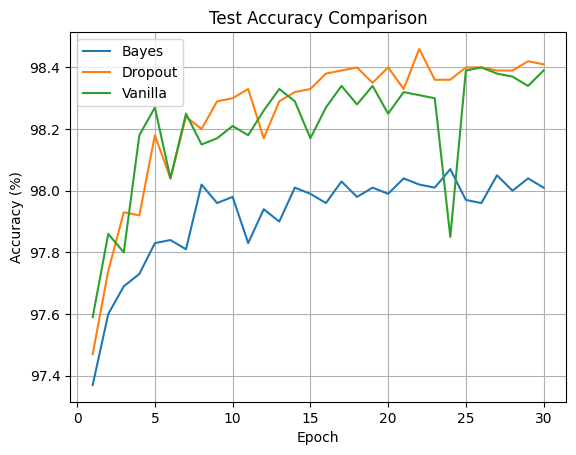

In [13]:
plt.plot(range(1, epochs+1), accs['Bayes'], label='Bayes')
plt.plot(range(1, epochs+1), accs['Dropout'], label='Dropout')
plt.plot(range(1, epochs+1), accs['Vanilla'], label='Vanilla')
plt.xlabel('Epoch'); plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Comparison')
plt.legend(); plt.grid(True); plt.show()

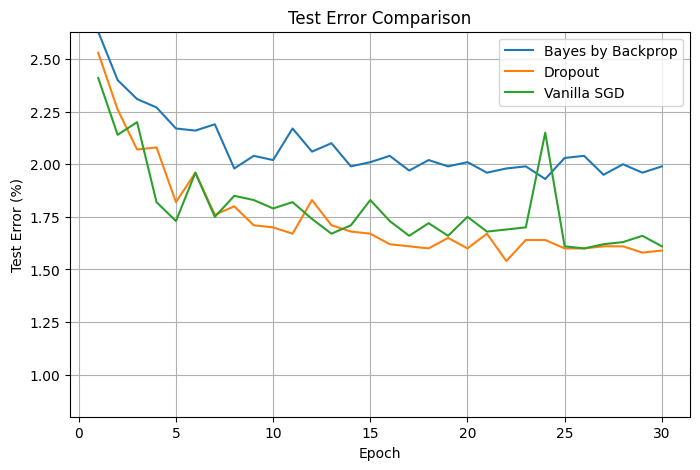

In [24]:
# Plot Test Error Comparison instead of Accuracy
error_bayes   = [100. - a for a in accs['Bayes']]
error_dropout = [100. - a for a in accs['Dropout']]
error_vanilla = [100. - a for a in accs['Vanilla']]

plt.figure(figsize=(8,5))
plt.plot(range(1, epochs+1), error_bayes,   label='Bayes by Backprop')
plt.plot(range(1, epochs+1), error_dropout, label='Dropout')
plt.plot(range(1, epochs+1), error_vanilla, label='Vanilla SGD')
# Set y-axis limits
plt.ylim(0.8, max(max(error_bayes), max(error_dropout), max(error_vanilla)))
plt.xlabel('Epoch')
plt.ylabel('Test Error (%)')
plt.title('Test Error Comparison')
plt.legend()
plt.grid(True)
plt.show()

This histogram displays the distribution of the posterior means μ of the first layer. A broad distribution indicates model flexibility, whereas narrow peaks suggest strong regularization. Such analysis corresponds to Figure 3 in the original paper.

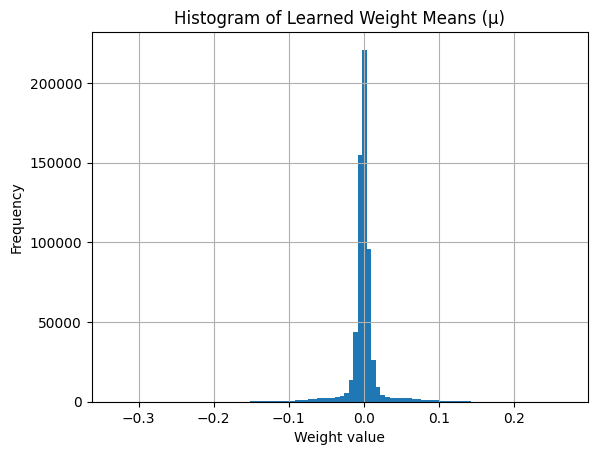

In [25]:
weights = bayes_model.fc1.mu_weight.detach().cpu().numpy().flatten()
plt.hist(weights, bins=100)
plt.title('Histogram of Learned Weight Means (μ)')
plt.xlabel('Weight value'); plt.ylabel('Frequency')
plt.grid(True); plt.show()

This plot overlays the posterior means μ of the Bayesian model's first layer and the raw weight values w of the Dropout and Vanilla baselines. By normalizing to density, we compare how the scale-mixture prior (Eq. 7) spreads the learned μ relative to deterministic SGDs. In the original paper’s Figure 3, Bayes by Backprop exhibits a broader, flatter distribution, indicating richer model averaging and regularization effects.

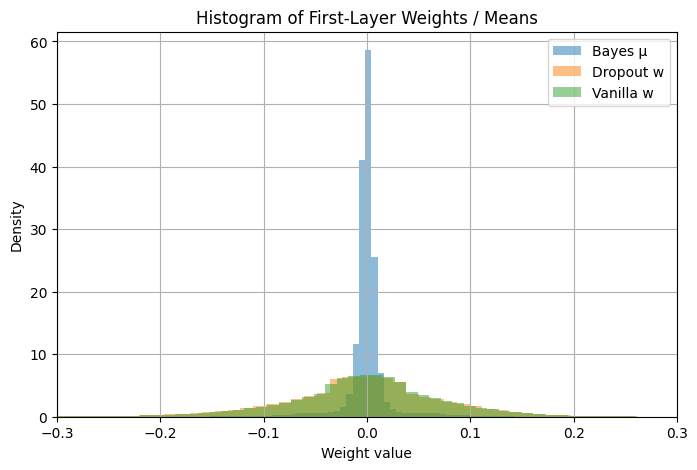

In [26]:
# Histogram of Weight Distributions for All Models
# Extract weights
bayes_mu    = bayes_model.fc1.mu_weight.detach().cpu().numpy().flatten()
drop_wts    = dropout_model.fc1.weight.detach().cpu().numpy().flatten()
vanilla_wts = vanilla_model.fc1.weight.detach().cpu().numpy().flatten()

# Plot overlayed histograms
plt.figure(figsize=(8,5))
plt.hist(bayes_mu,    bins=100, alpha=0.5, label='Bayes μ',    density=True)
plt.hist(drop_wts,    bins=100, alpha=0.5, label='Dropout w', density=True)
plt.hist(vanilla_wts, bins=100, alpha=0.5, label='Vanilla w', density=True)
plt.title('Histogram of First-Layer Weights / Means')
plt.xlabel('Weight value')
plt.ylabel('Density')
plt.xlim(-0.3, 0.3)
plt.legend()
plt.grid(True)
plt.show()

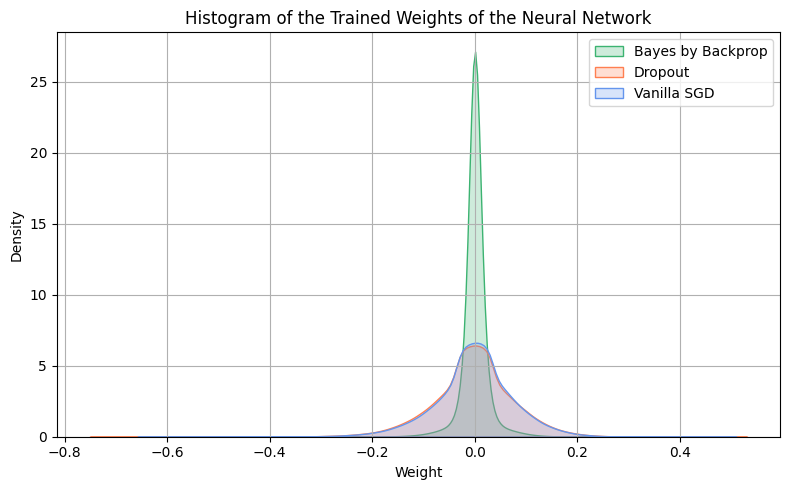

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Bayes: Ambil beberapa sampel
mu = bayes_model.fc1.mu_weight.data.cpu().numpy()
rho = bayes_model.fc1.rho_weight.data.cpu().numpy()
sigma = np.log1p(np.exp(rho))

samples = []
for _ in range(100):
    eps = np.random.randn(*mu.shape)
    sample = mu + sigma * eps
    samples.append(sample.flatten())
bayes_samples_concat = np.concatenate(samples)

# Dropout & Vanilla
dropout_weights = dropout_model.fc1.weight.data.cpu().numpy().flatten()
vanilla_weights = vanilla_model.fc1.weight.data.cpu().numpy().flatten()

# Plot KDE dengan bandwidth lembut
plt.figure(figsize=(8, 5))
sns.kdeplot(bayes_samples_concat, fill=True, label='Bayes by Backprop', bw_adjust=2.0, color='mediumseagreen')
sns.kdeplot(dropout_weights, fill=True, label='Dropout', bw_adjust=1.5, color='coral')
sns.kdeplot(vanilla_weights, fill=True, label='Vanilla SGD', bw_adjust=1.5, color='cornflowerblue')

plt.title("Histogram of the Trained Weights of the Neural Network")
plt.xlabel("Weight")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()